['hammer1.dat', 'hammer4.dat', 'hammer5.dat', 'hammer9.dat', 'hammer11.dat', 'hammer13.dat']


(0.0, 10000.0)

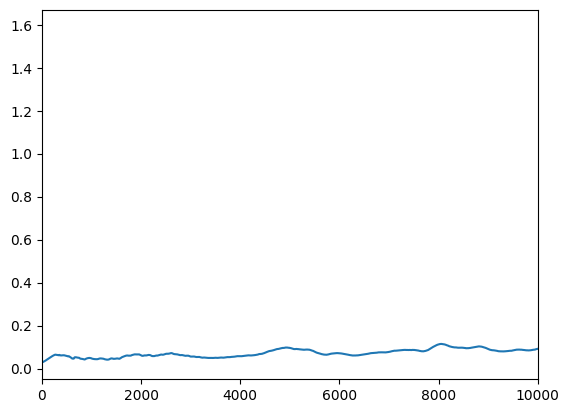

In [9]:
%matplotlib inline
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
from numpy.fft import rfft, irfft 
import re
import sys, os

warnings.filterwarnings("ignore")
# Add the directory containing the package to sys.path
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/ManipViolon_Anech_08062023")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
import Tools3D as tools3d

package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/RayoVox")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
import swd as swd

#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
DatFiles = [f for f in os.listdir('./') if f.endswith('.dat')]
DatFiles = [DatFiles[i] for i in [0,3,4,5,1,2]]
print(DatFiles)
NbMems = 256
NbVoies = 260
Fe = 50000
WinLen = 10000
iDly = 5
NbPings = 5
NbViol = 6
SensMems = 3.54e-6 # Pa/digit
SensHammer = 1000# N/V
SensAnalog = 0.337# V/digit
FRFMems1 = np.load('FRFMemsHOSMAAvg.npz')['FRF']
fMems1 = np.load('FRFMemsHOSMAAvg.npz')['f']
_=plt.plot(fMems1,FRFMems1)
plt.xlim(0,10000)



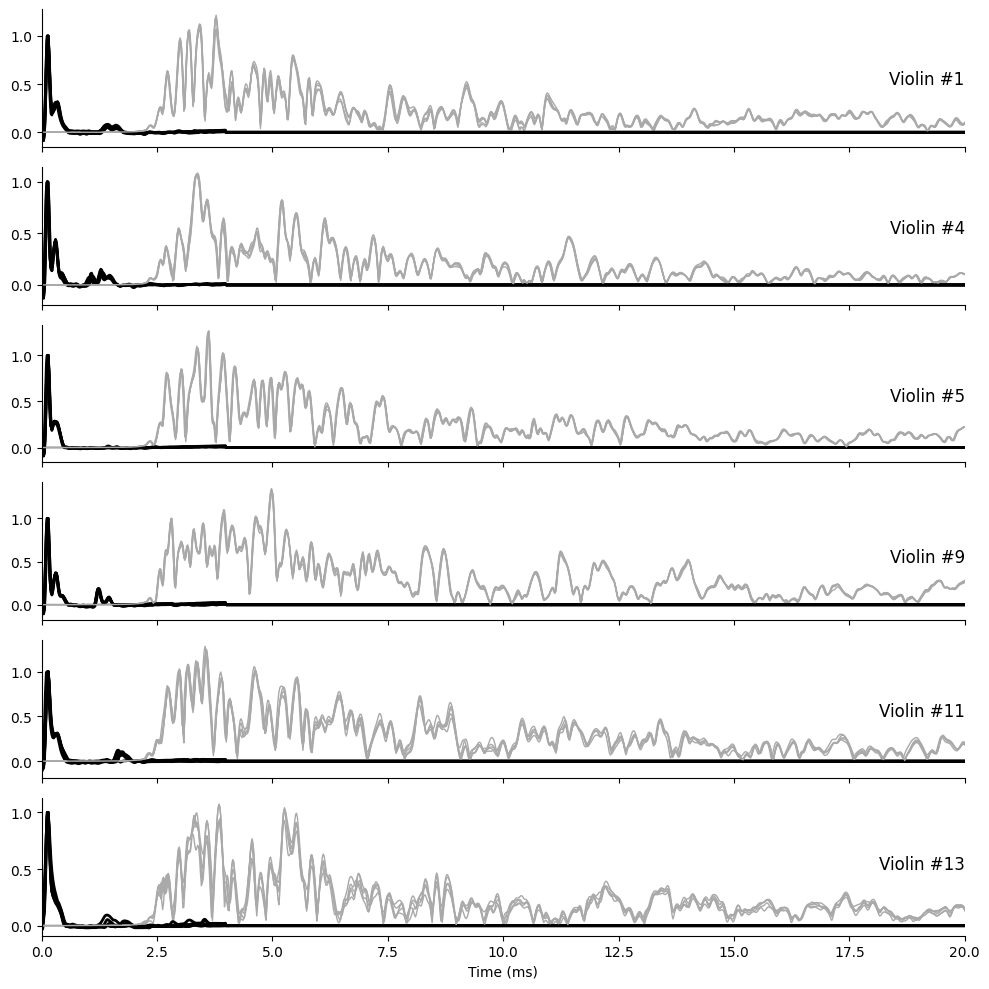

In [10]:
from scipy.signal import butter, filtfilt, hilbert
Thrshld = 0.5
# Design a Butterworth filter
cutoffL = 100  # Cutoff frequency in Hz
cutoffH = 10000  # Cutoff frequency in Hz

order = 6  # Filter order
b, a = butter(order, np.array([cutoffL, cutoffH]) / (0.5 * Fe), btype='Bandpass')

FramesHmr = []
FramesMcr = []
FramesMms = []
fig,ax = plt.subplots(6,1,figsize=(10,10)) 
nf = -1 
NumViolon = []  
for f in DatFiles:
    NumViolon.append(int(re.findall(r'\d+', f)[0]))
    nf += 1
    with open('./' + f) as DatFile : 
        data = np.fromfile(DatFile, dtype='int32').reshape((-1, NbVoies))
        compteur = data[:,0]
        Mems = data[:, 1:NbMems+1].astype('float')*SensMems
        Refs = data[:, NbMems+1:].astype('float')*SensAnalog
        NbEch = data.shape[0]
        t = np.arange(NbEch)/Fe
    Hammer = Refs[:,2]*SensHammer
    Hammer = filtfilt(b,a,Hammer)
    Micref = Refs[:,1]
    Micref = filtfilt(b,a,Micref)    
    Mems = filtfilt(b, a, Mems, axis = 0)
    
    tW = np.arange(WinLen)/Fe
    tWMax = 0.02
    for i in range(NbPings):
        Ham = Hammer/np.max(np.abs(Hammer))
        for j in range(len(Hammer)):
            if Ham[j] > Thrshld:
                iTrig = j - iDly
                j += WinLen - iDly
                Hmr = Hammer[iTrig:iTrig+WinLen]                
                Mcr = Micref[iTrig:iTrig+WinLen]
                Mms = Mems[iTrig:iTrig+WinLen, :]  
                Hmr[200:] = 0
                inegs = np.where(Hmr[:200] < 0)
                Hmr[:200] -= np.mean(Hmr[inegs]) 
                HmrN = Hmr/np.max(np.abs(Hmr))
                McrN = Mcr/np.max(np.abs(Mcr))
                MmsN = Mms/np.max(np.abs(Mms), axis=0)[None,:]
                
                ax[nf].plot(1000*tW,HmrN,'k', lw = 2)
                # ax[nf].plot(1000*tW,McrN,'b', lw = 2)
                # ax[nf].plot(1000*tW,MmsN[:,0],'grey', lw = 0.2)
                # ax[nf].plot(1000*tW,np.abs(hilbert(McrN)),'k', lw = 1)
                ax[nf].plot(1000*tW,np.abs(hilbert(MmsN[:,0])),'darkgrey', lw = 1)
                FramesHmr.append(Hmr)
                FramesMcr.append(Mcr)
                FramesMms.append(Mms)
                break     
        Hammer = Hammer[j:]
        Micref = Micref[j:] 
        Mems = Mems[j:,:]    
    ax[nf].set_xlim([0, 1000*tWMax])
    ax[nf].text(1000*tWMax, 0.5, f'Violin #{NumViolon[nf]:d}', fontsize=12, ha='right')
    # Remove borders
    ax[nf].spines['top'].set_visible(False)
    ax[nf].spines['right'].set_visible(False)

    # Remove tick labels
    if nf < 5:
        ax[nf].set_xticklabels([])
    else:    
        ax[nf].set_xlabel('Time (ms)')
        
    # Keep axis and ticks
    ax[nf].xaxis.set_ticks_position('bottom')
    ax[nf].yaxis.set_ticks_position('left')
fig.tight_layout()
FramesHmr = np.array(FramesHmr).reshape((NbViol, NbPings, WinLen))[:,:,:,None]  
FramesMcr =  np.array(FramesMcr).reshape((NbViol, NbPings, WinLen))[:,:,:,None]
FramesMms = np.array(FramesMms).reshape((NbViol, NbPings, WinLen, NbMems))
        
np.savez('./PingsAll.npz', t=t, Hmr=FramesHmr, Mcr = FramesMcr, Mms = FramesMms)
np.savez('./NumViolon.npz', NumViolon=NumViolon)


## Calcul des cohérences, fonctions de transfert et RIs

In [11]:
# DSPs
Shh = np.mean(np.abs(rfft(FramesHmr, axis=2))**2, axis=1)
Srr = np.mean(np.abs(rfft(FramesMcr, axis=2))**2, axis=1)
Smm = np.mean(np.abs(rfft(FramesMms, axis=2))**2, axis=1)
#CSPs
Shr = np.mean(np.conj( rfft(FramesHmr, axis=2)) * (rfft(FramesMcr, axis=2)), axis=1)
Shm = np.mean(np.conj( rfft(FramesHmr, axis=2)) * (rfft(FramesMms, axis=2)), axis=1)
Srm = np.mean(np.conj( rfft(FramesMcr, axis=2)) * (rfft(FramesMms, axis=2)), axis=1)
#Cohérences
Cohr = np.abs(Shr)**2 / (Shh * Srr)
Cohm = np.abs(Shm)**2 / (Shh * Smm)
Corm = np.abs(Srm)**2 / (Srr * Smm)
#FRFs
Hhr = Shr / Shh 
Hhm = Shm / Shh
Hrm = Srm / Srr
#RIs
RIhr = irfft(Hhr, axis=1)
RIhm = irfft(Hhm, axis=1)
RIrm = irfft(Hrm, axis=1)

frq = np.fft.rfftfreq(WinLen, 1/Fe)
np.savez('./ViolinsFRFs.npz', frq=frq, Shh=Shh, Srr=Srr, Smm=Smm, Shr=Shr, Shm=Shm, Srm=Srm, Cohr=Cohr, Cohm=Cohm, Corm=Corm, Hhr=Hhr, Hhm=Hhm, Hrm=Hrm, RIhr=RIhr, RIhm=RIhm, RIrm=RIrm)


### Systeme Linéaire Marteau-Micro de reference

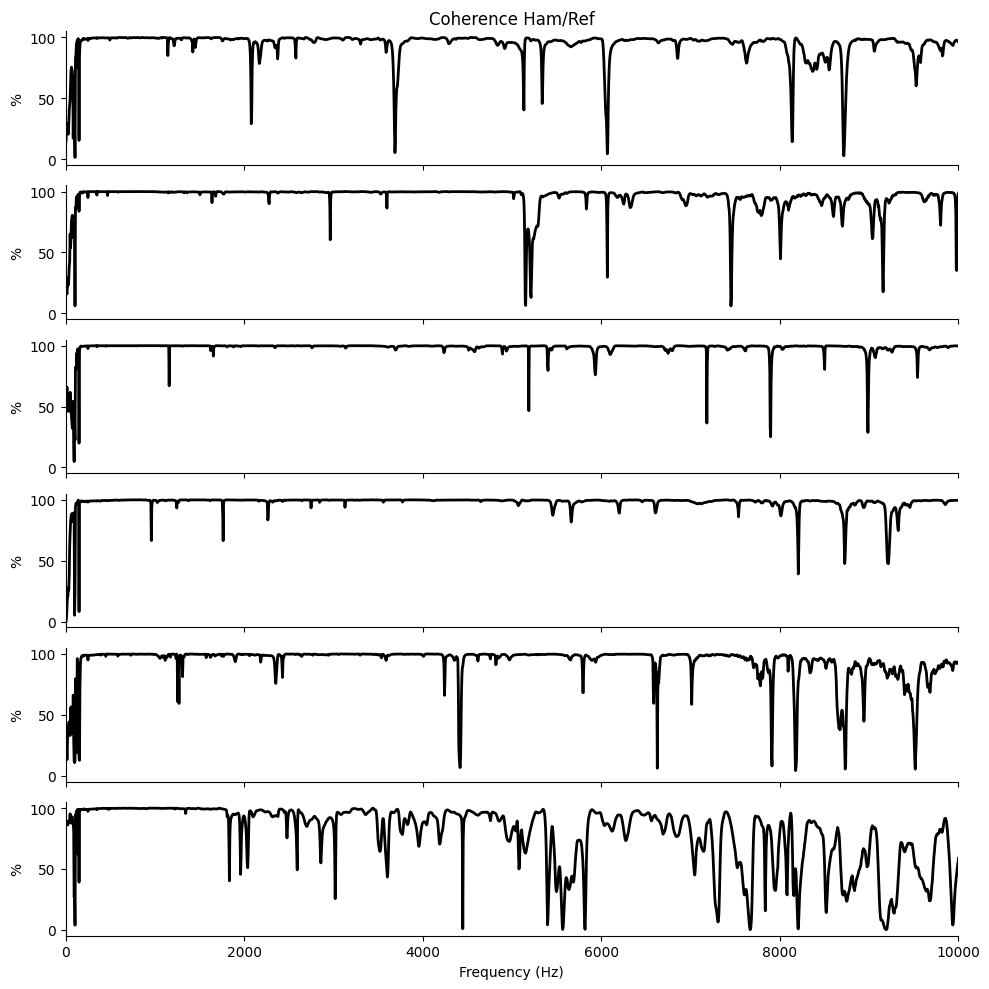

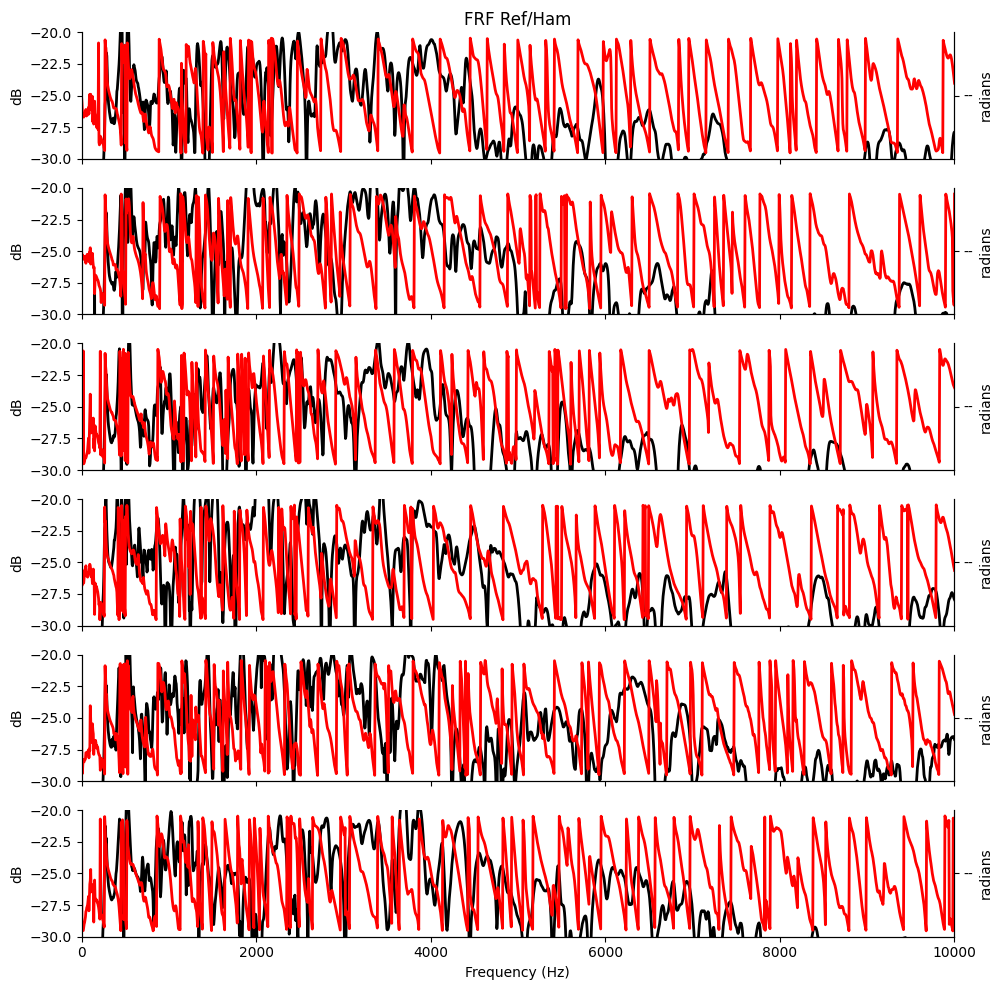

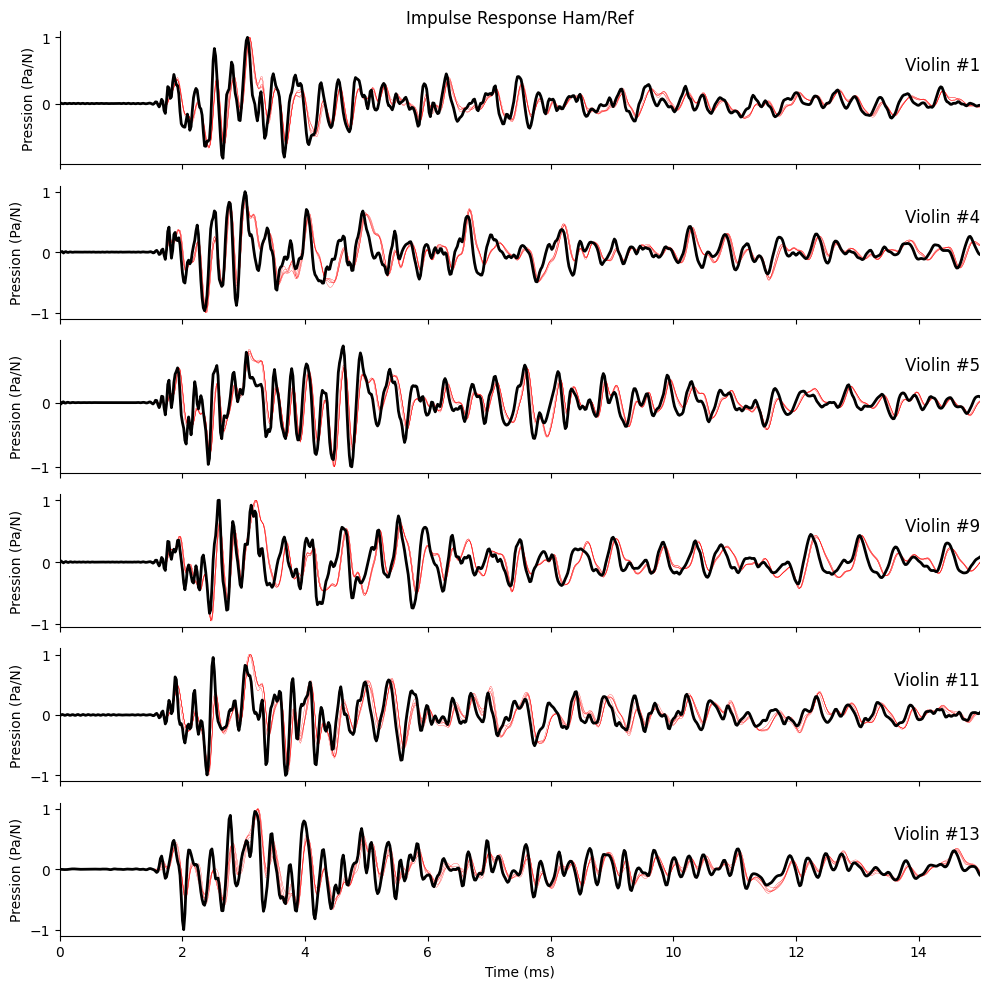

In [12]:
frqMax = 10000
tWMax = 0.015
fig21, ax21 = plt.subplots(6,1,figsize=(10,10))
fig22, ax22 = plt.subplots(6,1,figsize=(10,10))
fig23, ax23 = plt.subplots(6,1,figsize=(10,10))
for nf in range(NbViol):
    #Cohérence
    ax21[nf].plot(frq, 100*Cohr[nf,:], 'k', lw = 2)
    ax21[nf].set_xlim([0, frqMax])
    ax21[nf].set_ylabel('%')
    ax21[nf].spines['top'].set_visible(False)
    ax21[nf].spines['right'].set_visible(False)
    ax21[nf].xaxis.set_ticks_position('bottom')
    ax21[nf].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nf < 5:
        ax21[nf].set_xticklabels([])
    else:    
        ax21[nf].set_xlabel('Frequency (Hz)')
    if not nf : 
        ax21[nf].set_title('Coherence Ham/Ref')
   
    #FRF Amplitude
    ax22[nf].plot(frq, 10*np.log10(np.abs(Hhr[nf,:])), 'k', lw = 2, zorder = 1)
    ax22[nf].set_xlim([0, frqMax])
    ax22[nf].set_ylim([-30, -20])
    ax22[nf].set_ylabel('dB')
    ax22[nf].spines['top'].set_visible(False)
    ax22[nf].xaxis.set_ticks_position('bottom')
    ax22[nf].yaxis.set_ticks_position('left')
    #FRF Phase
    ax2b = ax22[nf].twinx()
    ax2b.plot(frq, np.unwrap(np.angle(Hhr[nf,:])), 'r', '--', lw = 2, zorder = 0)  
  
    #ax2b.set_ylim([-np.pi, np.pi])  
    ax2b.set_ylabel('radians')

    ax2b.xaxis.set_ticks_position('bottom')
    ax2b.yaxis.set_ticks_position('right')
    ax2b.spines['top'].set_visible(False)                    
    if nf < 5:
        ax22[nf].set_xticklabels([])
    else:    
        ax22[nf].set_xlabel('Frequency (Hz)')
        ax2b.set_xlabel('Frequency (Hz)')

    if not nf : 
        ax22[nf].set_title('FRF Ref/Ham')
    #RI    
    FramesMcr = FramesMcr.squeeze() 
    RIhr = RIhr.squeeze() 

    FramesMcrN = FramesMcr/np.max(np.abs(FramesMcr), axis=2)[:,:,None]
    RIhrN = RIhr[nf,:]/np.max(np.abs(RIhr[nf,:]))
    ax23[nf].plot(1000*(tW-iDly/Fe), FramesMcrN[nf,:,:].T, 'r', lw = 0.2)
    ax23[nf].plot(1000*tW, RIhrN, 'k', lw = 2)
    
    ax23[nf].set_xlim([0, 1000*tWMax])
    ax23[nf].set_ylabel('Pression (Pa/N)')
    ax23[nf].text(1000*tWMax, 0.5, f'Violin #{NumViolon[nf]:d}', fontsize=12, ha='right')

    ax23[nf].spines['top'].set_visible(False)
    ax23[nf].spines['right'].set_visible(False)
    ax23[nf].xaxis.set_ticks_position('bottom')
    ax23[nf].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nf < 5:
        ax23[nf].set_xticklabels([])
    else:    
        ax23[nf].set_xlabel('Time (ms)')
    if not nf : 
        ax23[nf].set_title('Impulse Response Ham/Ref')
fig21.tight_layout()
fig22.tight_layout()
fig23.tight_layout()

### Systeme Linéaire Marteau-Micro de l'antenne

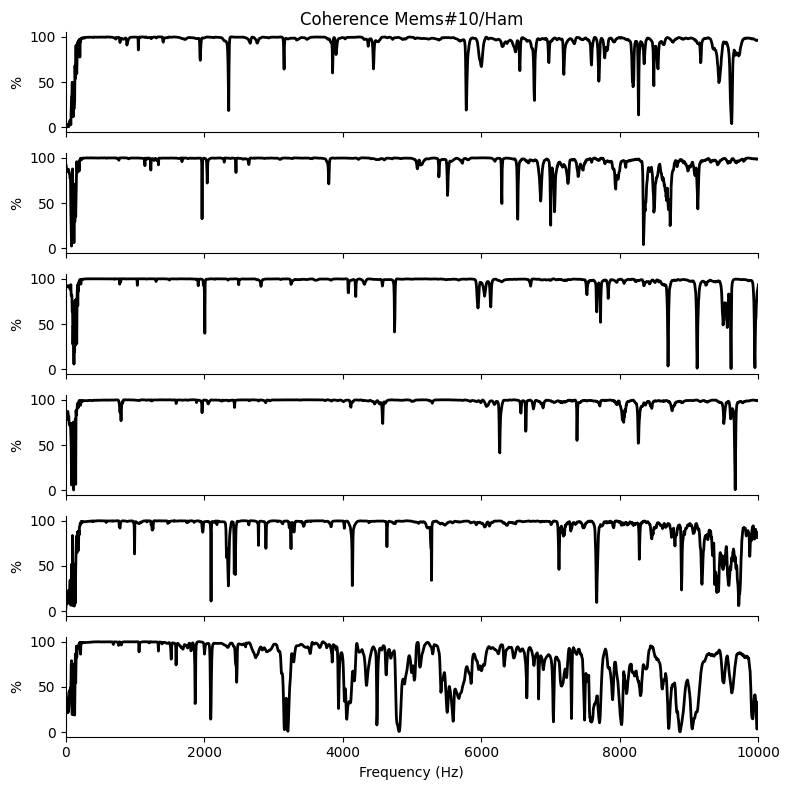

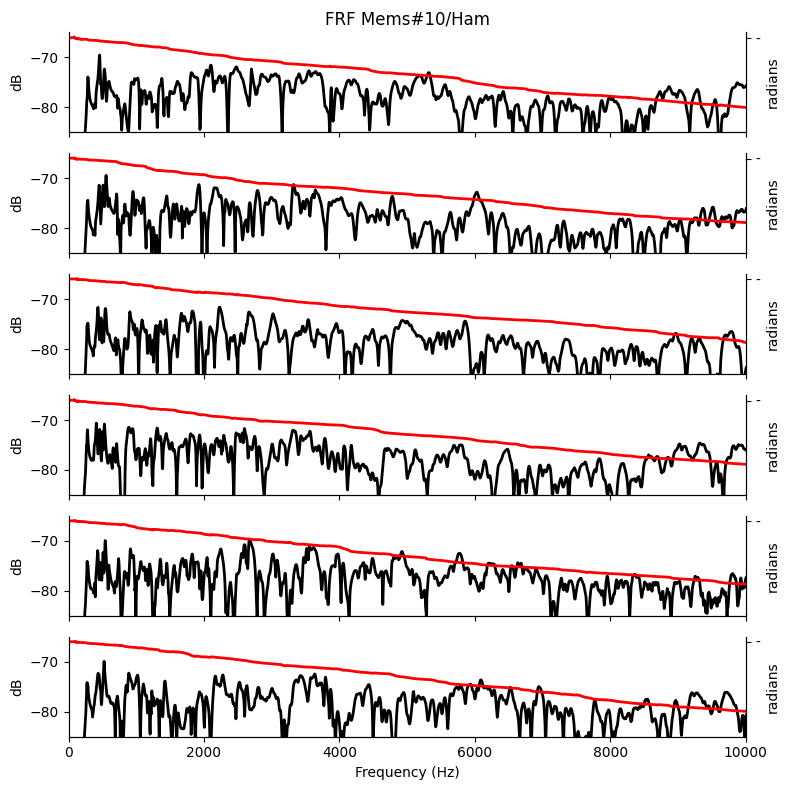

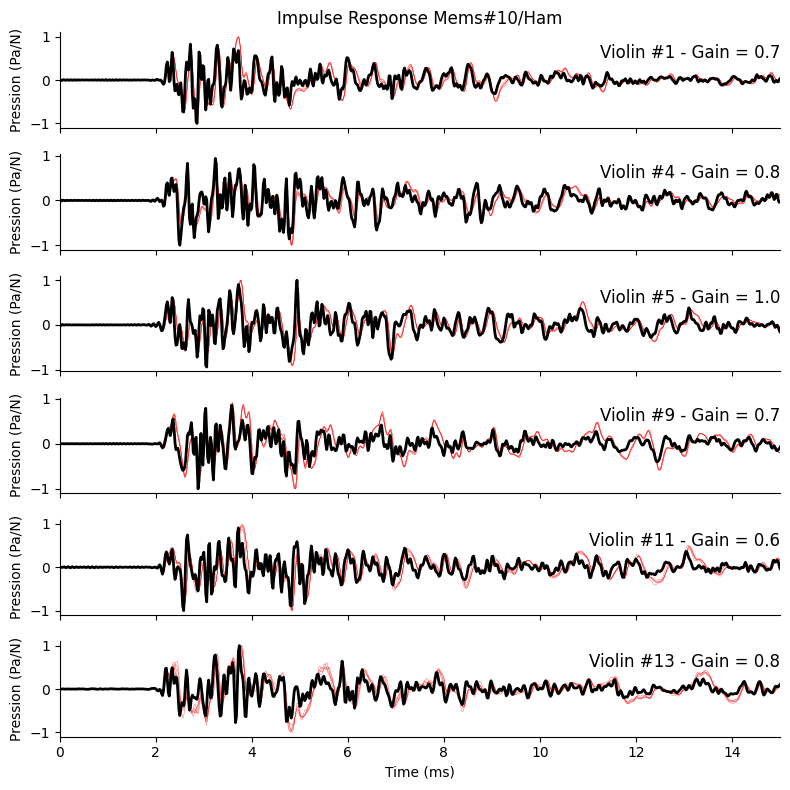

In [13]:
frqMax = 10000
tWMax = 0.015
nm = 10

Cohmin = np.min(Cohm[:,:,::16],axis=2)
Cohmax = np.max(Cohm[:,:,::16],axis=2)
CohAvg = np.mean(Cohm[:,:,::16],axis=2)

FRFmin = np.min(np.abs(Hhm[:,:,::25]),axis=2)
FRFmax = np.max(np.abs(Hhm[:,:,::25]),axis=2)
FRFAvg = np.mean(np.abs(Hhm[:,:,::25]),axis=2)

fig31, ax31 = plt.subplots(6,1,figsize=(8,8))
fig32, ax32 = plt.subplots(6,1,figsize=(8,8))
fig33, ax33 = plt.subplots(6,1,figsize=(8,8))
for nf in range(NbViol):
    #Cohérence
    #ax31[nf].fill_between(frq, Cohmin[nf,:], Cohmax[nf,:], color='lightblue', alpha=0.5, label='Min-Max Range')
    #ax31[nf].plot(frq, CohAvg[nf,:], color='blue', label='Mean', linewidth=2)
    ax31[nf].plot(frq, 100*Cohm[nf,:,nm], 'k', lw = 2)
    ax31[nf].set_xlim([0, frqMax])
    ax31[nf].set_ylabel('%')
    ax31[nf].spines['top'].set_visible(False)
    ax31[nf].spines['right'].set_visible(False)
    ax31[nf].xaxis.set_ticks_position('bottom')
    ax31[nf].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nf < 5:
        ax31[nf].set_xticklabels([])
    else:    
        ax31[nf].set_xlabel('Frequency (Hz)')
    if not nf : 
        ax31[nf].set_title('Coherence Mems#10/Ham')
    #FRF Amplitude
    #ax32[nf].fill_between(frq, 10*np.log10(FRFmin[nf,:]), 10*np.log10(FRFmax[nf,:]), color='lightblue', alpha=0.5, label='Min-Max Range')
    #ax32[nf].plot(frq, 10*np.log10(FRFAvg[nf,:]), color='blue', label='Mean', linewidth=2)
    ax32[nf].plot(frq, 10*np.log10(np.abs(Hhm[nf,:,nm])), 'k', lw = 2, zorder = 2)
    ax32[nf].set_xlim([0, frqMax])
    ax32[nf].set_ylim([-85, -65])
    ax32[nf].set_ylabel('dB')
    ax32[nf].spines['top'].set_visible(False)
    ax32[nf].xaxis.set_ticks_position('bottom')
    ax32[nf].yaxis.set_ticks_position('left')
    #FRF Phase
    ax3b = ax32[nf].twinx()
    ax3b.plot(frq, np.unwrap(np.angle(Hhm[nf,:,nm])),'r', '-', lw = 2, zorder = 1 )  
    #ax3b.set_ylim([-np.pi, np.pi])  
    ax3b.set_ylabel('radians')
    ax3b.xaxis.set_ticks_position('bottom')
    ax3b.yaxis.set_ticks_position('right')
    ax3b.spines['top'].set_visible(False)                    
    if nf < 5:
        ax32[nf].set_xticklabels([])
    else:    
        ax32[nf].set_xlabel('Frequency (Hz)')
    if not nf : 
        ax32[nf].set_title('FRF Mems#10/Ham')
    #RI    
    FramesMms = FramesMms.squeeze() 
    RIhm = RIhm.squeeze() 
    Gain = 1/np.max(np.abs(RIhm),axis = 1)[:,None,:]
    FramesMmsN = FramesMms/np.max(np.abs(FramesMms), axis=2)[:,:,None]
    RIhmN = RIhm*Gain
    Gain /= np.max(np.abs(Gain), axis=0)
    ax33[nf].plot(1000*(tW-iDly/Fe), FramesMmsN[nf,:,:,nm].T, 'r', lw = 0.2)
    ax33[nf].plot(1000*tW, RIhmN[nf, :, nm], 'k', lw = 2)    
    
    ax33[nf].set_xlim([0, 1000*tWMax])
    ax33[nf].set_ylabel('Pression (Pa/N)')
    ax33[nf].text(1000*tWMax, 0.5, f'Violin #{NumViolon[nf]:d} - Gain = {Gain[nf,0,nm]:.1f}', fontsize=12, ha='right')

    ax33[nf].spines['top'].set_visible(False)
    ax33[nf].spines['right'].set_visible(False)
    ax33[nf].xaxis.set_ticks_position('bottom')
    ax33[nf].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nf < 5:
        ax33[nf].set_xticklabels([])
    else:    
        ax33[nf].set_xlabel('Time (ms)')
    if not nf : 
        ax33[nf].set_title('Impulse Response Mems#10/Ham')
fig31.tight_layout()
fig32.tight_layout()
fig33.tight_layout()
np.savez('./ViolinsPm.npz', frq=frq, Pm = Hhm)

### Systeme Linéaire Micro Ref-Micro de l'antenne

## Analyse de la RI comme RIR
Les indices standards extraits de l'analyse de la réponse impulsionnelle d'une salle incluent généralement les suivants :

1. **Temps de Réverbération (RT60)** : Le temps nécessaire pour que le niveau sonore diminue de 60 dB après l'arrêt de la source sonore.

2. **Early Decay Time (EDT)** : Le temps nécessaire pour que le niveau sonore diminue de 10 dB, extrapolé pour estimer le RT60.

3. **Clarity (C50, C80)** : Mesure de la clarté du son, définie comme le rapport entre l'énergie sonore précoce (dans les 50 ms ou 80 ms) et l'énergie sonore tardive.

4. **Définition (D50)** : Le pourcentage de l'énergie sonore totale qui arrive dans les 50 ms suivant l'arrivée du son direct.

5. **Centre Temporel (Ts)** : Le moment où l'énergie cumulative atteint 50 % de l'énergie totale.

6. **Rapport Signal/Bruit (SNR)** : Le rapport entre le niveau du signal utile et le niveau du bruit de fond.


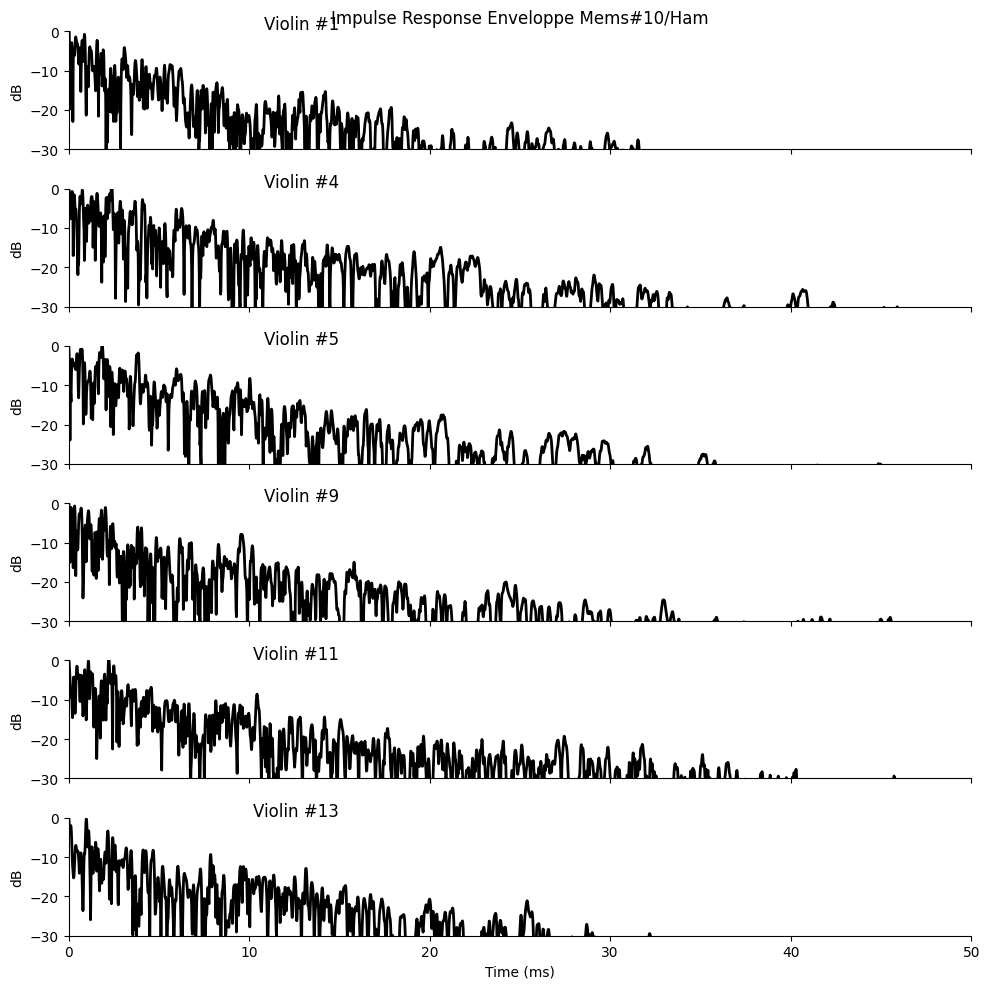

In [14]:
Env = np.abs(hilbert(RIhmN, axis=1))
EnvdB = 20*np.log10(Env)
fig41, ax41 = plt.subplots(6,1,figsize=(10,10))
imaxRI = np.argmax(Env, axis=1)
for nf in range(NbViol):
    #RI    
    ax41[nf].plot(1000*(tW-tW[imaxRI[nf,nm]]), EnvdB[nf, :, nm], 'k', lw = 2)    
    
    ax41[nf].set_xlim([0, 50])
    ax41[nf].set_ylim([-30, 0])

    ax41[nf].set_ylabel('dB')
    ax41[nf].text(1000*tWMax, 0.5, f'Violin #{NumViolon[nf]:d}', fontsize=12, ha='right')

    ax41[nf].spines['top'].set_visible(False)
    ax41[nf].spines['right'].set_visible(False)
    ax41[nf].xaxis.set_ticks_position('bottom')
    ax41[nf].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nf < 5:
        ax41[nf].set_xticklabels([])
    else:    
        ax41[nf].set_xlabel('Time (ms)')
    if not nf : 
        ax41[nf].set_title('Impulse Response Enveloppe Mems#10/Ham')
fig41.tight_layout()


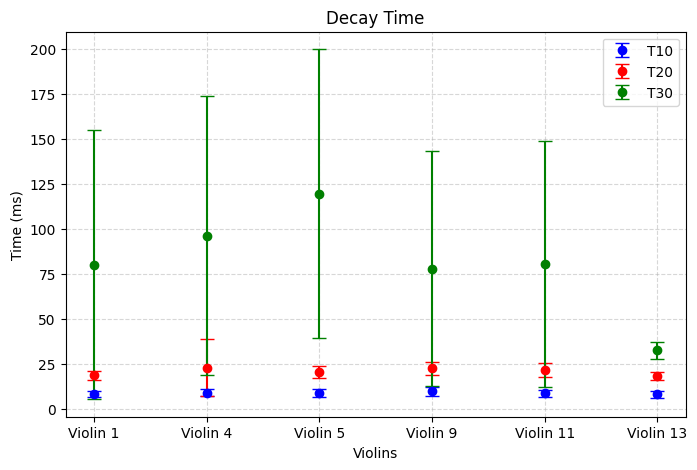

In [15]:
LastOver10 = np.zeros((NbViol,NbMems))
LastOver20 = np.zeros((NbViol,NbMems))
LastOver30 = np.zeros((NbViol,NbMems))
for v in range(NbViol):
    for m in range(NbMems):
        for i in range(EnvdB.shape[1]):
            if EnvdB[v,i,m] > -10 :
                LastOver10[v,m] = tW[i]*1000
            if EnvdB[v,i,m] > -20 :
                LastOver20[v,m] = tW[i]*1000
            if EnvdB[v,i,m] > -30 :
                LastOver30[v,m] = tW[i]*1000

means10 = np.mean(LastOver10, axis=1)
std_devs10 = np.std(LastOver10, axis=1)
means20 = np.mean(LastOver20, axis=1)
std_devs20 = np.std(LastOver20, axis=1)
means30 = np.mean(LastOver30, axis=1)
std_devs30 = np.std(LastOver30, axis=1)

# X-axis positions for the violins
x_positions = np.arange(1, NbViol + 1)

                
# Scatter plot with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(x_positions, means10, yerr=std_devs10, fmt='o', capsize=5, label='T10', color='blue')
plt.errorbar(x_positions, means20, yerr=std_devs20, fmt='o', capsize=5, label='T20', color='red')
plt.errorbar(x_positions, means30, yerr=std_devs30, fmt='o', capsize=5, label='T30', color='green')
# Add labels and title
plt.xticks(x_positions, [f"Violin {NumViolon[i-1]}" for i in x_positions])
plt.xlabel("Violins")
plt.ylabel("Time (ms)")
plt.title("Decay Time")
plt.legend()
plt.grid()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()